In [1]:
import pandas as pd

weekly_df = pd.read_csv("/Users/vietanh/Documents/doan/preprocess/weekly_data.csv")
weekly_df.head()


,Ticker,Date,Open,High,Low,Close,Volume,VWAP
0,A32,2018-10-28,12.85,12.85,12.85,12.85,0,0.0
1,A32,2018-11-04,12.85,12.85,12.85,12.85,0,0.0
2,A32,2018-11-11,12.85,12.85,12.85,12.85,0,0.0
3,A32,2018-11-18,12.85,12.85,12.85,12.85,0,0.0
4,A32,2018-11-25,12.85,12.85,12.85,12.85,0,0.0


/var/folders/wd/3xl8mn_n2fl_99tcg2cxx9hr0000gn/T/ipykernel_38007/4275876532.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=tickers_per_year, x="Năm", y="Số lượng mã cổ phiếu", palette="crest")


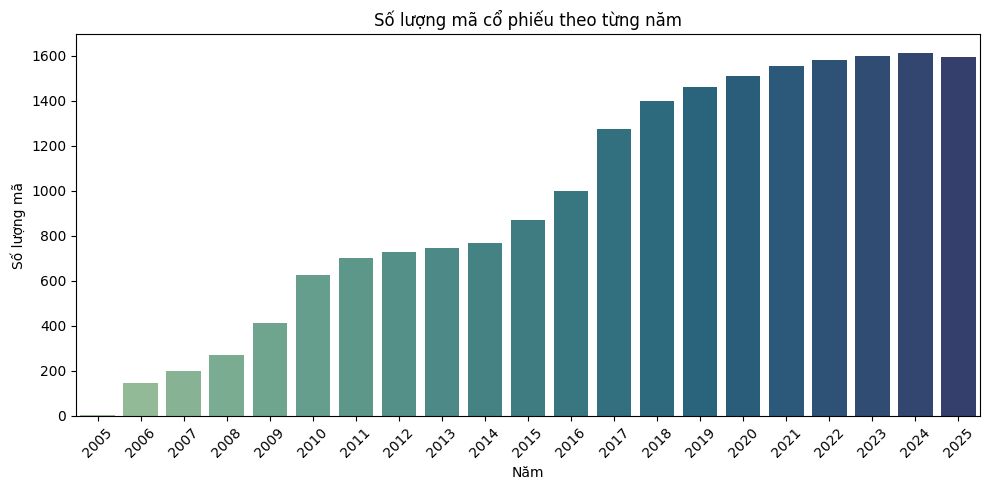

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

weekly_df["Date"] = pd.to_datetime(weekly_df["Date"])

weekly_df["Year"] = weekly_df["Date"].dt.year

tickers_per_year = weekly_df.groupby("Year")["Ticker"].nunique().reset_index()
tickers_per_year.columns = ["Năm", "Số lượng mã cổ phiếu"]

plt.figure(figsize=(10, 5))
sns.barplot(data=tickers_per_year, x="Năm", y="Số lượng mã cổ phiếu", palette="crest")
plt.title("Số lượng mã cổ phiếu theo từng năm")
plt.ylabel("Số lượng mã")
plt.xlabel("Năm")
plt.xticks(rotation=45)
plt.tight_layout()

In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import skew, kurtosis

def calculate_rsi(series, window=14):
    delta = series.diff()
    up = np.where(delta > 0, delta, 0)
    down = np.where(delta < 0, -delta, 0)
    roll_up = pd.Series(up, index=series.index).rolling(window).mean()
    roll_down = pd.Series(down, index=series.index).rolling(window).mean()
    rs = roll_up / (roll_down + 1e-6)
    rsi = 100 - (100 / (1 + rs))
    return rsi

def calculate_atr(high, low, close, window=5):
    high_low = high - low
    high_close = (high - close.shift()).abs()
    low_close = (low - close.shift()).abs()
    tr = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)
    atr = tr.rolling(window).mean()
    return atr

file_path = '/Users/vietanh/Documents/doan/preprocess/weekly_data.csv'
df = pd.read_csv(file_path)
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values(by=['Ticker', 'Date'])

vni_df = df[df['Ticker'] == 'VNINDEX'][['Date', 'Close']].rename(columns={'Close': 'vni_close'})
vni_df['vni_t'] = vni_df['vni_close']
vni_df['vnipc_t'] = vni_df['vni_close'].pct_change()

df = df[df['Ticker'] != 'VNINDEX']

def compute_indicators(group):
    group = group.copy()

    group = group.merge(vni_df[['Date', 'vni_t', 'vnipc_t']], on='Date', how='left')

    group['ret'] = group['Close'].pct_change()
    group['Volatility'] = group['ret'].rolling(5).std()
    group['HL'] = group['High'] - group['Low']
    group['LO'] = group['Close'] - group['Low']
    group['SR'] = group['Close'] - group['Open']
    group['PM'] = (group['High'] + group['Low']) / 2
    group['MDD'] = (group['Close'] / group['Close'].cummax() - 1).cummin()
    group['TVV'] = group['Volume'].rolling(5).std()

    group['TR'] = pd.concat([
        (group['High'] - group['Low']),
        (group['High'] - group['Close'].shift()).abs(),
        (group['Low'] - group['Close'].shift()).abs()
    ], axis=1).max(axis=1)

    group['ATR'] = calculate_atr(group['High'], group['Low'], group['Close'])
    group['SK'] = group['Close'].rolling(5).apply(skew, raw=True)
    group['KU'] = group['Close'].rolling(5).apply(kurtosis, raw=True)
    group['RSI'] = calculate_rsi(group['Close'])
    group['Median_HL'] = (group['High'] + group['Low']) / 2
    group['fore_di_rt'] = group['Close'].shift(-1) / group['Close'] - 1
    group['label'] = (group['fore_di_rt'] >= 0).astype(int)

    group['variation_t'] = group['Close'] / group['Close'].shift(1) - 1
    group['ma7_t'] = group['Close'].rolling(7).mean()
    group['ma14_t'] = group['Close'].rolling(14).mean()
    group['ma21_t'] = group['Close'].rolling(21).mean()
    group['s_d7_t'] = group['Close'].rolling(7).std()

    group['t'] = np.arange(len(group))
    group['insec_t'] = group['Volume'] / (group['High'] - group['Low']).replace(0, np.nan)

    return group

df_indicators = df.groupby('Ticker').apply(compute_indicators).reset_index(drop=True)

output_path = '/Users/vietanh/Documents/doan/preprocess/weekly_data_full_indicators.csv'
df_indicators.to_csv(output_path, index=False)

print(f"✅ Đã lưu file kết quả tại: {output_path}")


/opt/anaconda3/envs/code/lib/python3.9/site-packages/pandas/core/window/rolling.py:1535: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return window_func(values, begin, end, min_periods)
/opt/anaconda3/envs/code/lib/python3.9/site-packages/pandas/core/window/rolling.py:1535: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return window_func(values, begin, end, min_periods)
/opt/anaconda3/envs/code/lib/python3.9/site-packages/pandas/core/window/rolling.py:1535: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return window_func(values, begin, end, min_periods)
/opt/anaconda3/envs/code/lib/python3.9/site-packages/panda

✅ Đã lưu file kết quả tại: /Users/vietanh/Documents/doan/preprocess/weekly_data_full_indicators.csv


In [14]:
# Convert 'Date' column again in case of reloading
df_indicators['Date'] = pd.to_datetime(df_indicators['Date'])

start_date = pd.to_datetime("2013-01-06")
end_date = pd.to_datetime("2025-04-13")

filtered_df = df_indicators[(df_indicators['Date'] >= start_date) & (df_indicators['Date'] <= end_date)]

ticker_counts = filtered_df['Ticker'].value_counts()

tickers_start = filtered_df[filtered_df['Date'] == start_date]['Ticker'].unique()
tickers_end = filtered_df[filtered_df['Date'] == end_date]['Ticker'].unique()

tickers_valid = set(tickers_start).intersection(set(tickers_end))

final_filtered_df = filtered_df[filtered_df['Ticker'].isin(tickers_valid)]

final_filtered_path = "/Users/vietanh/Documents/doan/preprocess/up_down.csv"
final_filtered_df.to_csv(final_filtered_path, index=False)


